In [177]:
import h5py
import numpy as np
import os
import pandas as pd
import subprocess
import time

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Load SAM data

In [142]:
def ProcessSAMdat_single_redshift_lite(path_to_SAM, Nsubvols, sought_z, fieldswanted, gal_or_halo):
    #NOTE: these ?_colnames are the columns, in order, of the data in the original .dat files. You can give fieldswanted in nearly any order, but the order that the columns will take in the final array will depend on the fields' order in these lists. NOTE: if you care about halo_index, birthhaloID, or roothaloID, redshift will NOT be in the 0th index; update the line below that assumes that!
    g_colnames = ['halo_index', 'birthhaloid', 'roothaloid', 'redshift', 'sat_type',
                  'mhalo', 'm_strip', 'rhalo', 'mstar', 'mbulge', 'mstar_merge', 'v_disk',
                  'sigma_bulge', 'r_disk', 'r_bulge', 'mcold', 'mHI', 'mH2', 'mHII', 'Metal_star',
                  "Metal_cold", 'sfr', 'sfrave20myr', 'sfrave100myr', 'sfrave1gyr',
                  'mass_outflow_rate', 'metal_outflow_rate', 'mBH', 'maccdot', 'maccdot_radio',
                  'tmerge', 'tmajmerge', 'mu_merge', 't_sat', 'r_fric', 'x_position',
                  'y_position', 'z_position', 'vx', 'vy', 'vz']
    h_colnames = ['halo_index', 'halo_id', 'roothaloid', 'orig_halo_ID', 'redshift', 'm_vir', 'c_nfw',
                  'spin', 'm_hot', 'mstar_diffuse', 'mass_ejected', 'mcooldot',
                  'maccdot_pristine', 'maccdot_reaccrete', 'maccdot_metal_reaccrete',
                  'maccdot_metal', 'mdot_eject', 'mdot_metal_eject', 'maccdot_radio',
                  'Metal_hot', 'Metal_ejected', 'snap_num']
    g_header_rows = []
    for i in range(0, len(g_colnames)):
        g_header_rows.append(i)
    h_header_rows = []
    for i in range(0, len(h_colnames)):
        h_header_rows.append(i)

    input_path=path_to_SAM

    if type(fieldswanted) == list:
        #print(type(fieldswanted))
        pass
    else:
        return "Fieldswanted should be a list with the fields you want as strings!"

    All_halos=np.zeros((1,len(fieldswanted)))
    if gal_or_halo=="gal":
        checknums=0
        for x_i in np.arange(0,Nsubvols,1):
            for x_j in np.arange(0,Nsubvols,1):
                for x_k in np.arange(0,Nsubvols,1):
                    #galprop = pd.read_csv('{}/{}_{}_{}/galprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                    #                      delimiter=' ', skiprows=g_header_rows, names=g_colnames)
                    # print('galprop read for ',x_i, x_j, x_k,' shape:', galprop.shape)
                    #current_galprops=galprop[fieldswanted[:]].to_numpy()
                    
                    galprop = pd.read_csv('{}/{}_{}_{}/galprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                                          delimiter=' ', skiprows=g_header_rows, names=g_colnames, 
                                          usecols=fieldswanted)            
                    #print(galprop)
                    current_galprops=galprop.to_numpy()
                    #print(current_galprops.shape)
                    
                    #print('For subvolume ',x_i,x_j,x_k, current_galprops.shape)
                    unique_redshifts=set(current_galprops[:,0]) #update this if redshift will NOT be in the 0th column; see note above
                    unique_redshifts = np.array(sorted(unique_redshifts))
                    # print(unique_redshifts)
                    idx = (np.abs(unique_redshifts - sought_z)).argmin()
                    current_galprops_z=current_galprops[np.where(current_galprops[:,0][:]==unique_redshifts[idx])[0],:]
                    # print(current_galprops_z.shape)
                    checknums=checknums+len(current_galprops_z)
                    All_halos=np.concatenate((All_halos,current_galprops_z))
                    #print(All_halos.shape)
        #print(All_halos.shape, checknums)
        return All_halos
    elif gal_or_halo=="halo":
        checknums2=0
        for x_i in np.arange(0,Nsubvols,1):
            for x_j in np.arange(0,Nsubvols,1):
                for x_k in np.arange(0,Nsubvols,1):
                    haloprop = pd.read_csv('{}/{}_{}_{}/haloprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                                           delimiter=' ', skiprows=h_header_rows, names=h_colnames)
                    current_haloprops=haloprop[fieldswanted[:]].to_numpy()
                    print('For subvolume ',x_i,x_j,x_k, current_haloprops.shape)
                    unique_redshifts=set(current_haloprops[:,0])
                    unique_redshifts = np.array(sorted(unique_redshifts))
                    idx = (np.abs(unique_redshifts - sought_z)).argmin()
                    current_haloprops_z=current_haloprops[np.where(current_haloprops[:,0][:]==unique_redshifts[idx])[0],:]
                    # print(current_haloprops_z.shape)
                    checknums2=checknums2+len(current_haloprops_z)
                    All_halos=np.concatenate((All_halos,current_haloprops_z))
        print(All_halos.shape, checknums2)
        return All_halos[1:,:]
    else:
        print("gal_or_halo need to be a string, either 'gal' or 'halo', to get galprop or haloprop respectively. Make sure the fields you want are actually reflected!")
        print("Column names of galprop file: ", g_colnames)
        print("Column names of haloprop file: ", h_colnames)
        return All_halos

In [175]:
#sim_nums = [613, 257, 61, 579, 96]#, 524, 581, 541, 647, 137]
sim_nums = [0]

In [183]:
galprop_fields = ['redshift', 'halo_index', 'sat_type', 'mstar', 'mhalo', 'rhalo', 'sfr', 'sfrave1gyr',
                  'x_position', 'y_position', 'z_position', 'vx', 'vy', 'vz', ]
redshift = 0

dir_sams = '/dipc/kstoreyf/CAMELS-SAM'
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM'

os.chdir(f'{dir_sams}/LH_{idx_sam}') 
totaldirs=(subprocess.check_output('''ls -l sc-sam/ | grep -c ^d''', shell=True,text=True))
totaldirs=np.float64(totaldirs)
Nsubvol=np.int64(totaldirs**(1./3.))

dats_sam = []
for idx_sam in sim_nums:
    print(f'Reading sam LH_{idx_sam}')
    dat_sam = ProcessSAMdat_single_redshift_lite(f'{dir_sams}/LH_{idx_sam}/sc-sam', 
                                                       Nsubvol, redshift, galprop_fields, 'gal')
    print('CAMELS-SAM simulation LH',idx_sam,' at redshift ', redshift, ' has this many galaxies: ', dat_sam.shape)
    #dats_sam.append(dat_sam)
    
    fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
    with h5py.File(fn_dat, 'w') as f:
        for i in range(len(galprop_fields)):
            if galprop_fields[i]!='redshift':
                f.create_dataset(galprop_fields[i], data=dat_sam[:,i], chunks=True)
                

Reading sam LH_0
CAMELS-SAM simulation LH 0  at redshift  0  has this many galaxies:  (174733, 6)


In [180]:
# test
fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
with h5py.File(fn_dat, 'w') as f:
    for i in range(len(galprop_fields)):
        if galprop_fields[i]!='redshift':
            f.create_dataset(galprop_fields[i], data=dat_sam[:,i], chunks=True)

In [182]:
with h5py.File(fn_dat, 'r') as f:
    x_arr = np.array(f['x_position'])
    print(x_arr.shape)
    print(x_arr.min(), x_arr.max())

(174733,)
-1.81249 149.232


In [145]:
dat = dats_sam[0]

In [146]:
dat.shape

(169837, 6)

In [147]:
x_arr = dat[:,galprop_fields.index('x_position')]
y_arr = dat[:,galprop_fields.index('y_position')]
z_arr = dat[:,galprop_fields.index('z_position')]

In [148]:
x_arr.min(), x_arr.max(), z_arr.min(), z_arr.max()

(-0.61627, 149.393, -0.484752, 150.051)

Why are some negative...! TODO figure out

box size: (100 Mpc/h)

positions in just Mpc

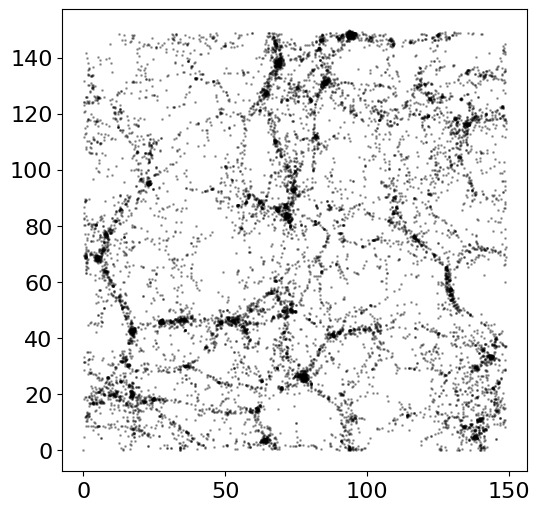

In [149]:
plt.figure(figsize=(6,6))
plt.scatter(x_arr[z_arr < 10], y_arr[z_arr < 10], color='k', s=1, alpha=0.3)


In [174]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2023-12-20 12:02:20,063 bacco.cosmo :    initialization took 0.000 secs
INFO:bacco.cosmo:   initialization took 0.000 secs


In [154]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


In [170]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':30,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [171]:
pos_arr.shape

(3, 169837)

2023-12-20 11:55:46,929 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
INFO:bacco.statistics:Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-20 11:55:46,931 bacco.statistics :  setting the grid 256 True
INFO:bacco.statistics: setting the grid 256 True
2023-12-20 11:55:46,932 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
INFO:bacco.statistics:Computing cic mesh with ngrid=256 and interlacing=True
2023-12-20 11:55:46,933 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2023-12-20 11:55:46,998 bacco.statistics :  mesh done in 0.0666 s
INFO:bacco.statistics: mesh done in 0.0666 s
2023-12-20 11:55:47,001 bacco.statistics :  Starting the power spectrum calculation
INFO:bacco.statistics: Starting the power spectrum calculation


rid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3 (grid1) 3 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 4.654149 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.457033 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000779 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3 (grid1) 3 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 

2023-12-20 11:55:47,254 bacco.statistics :  done compute.power
INFO:bacco.statistics: done compute.power
2023-12-20 11:55:47,255 bacco.statistics :  power done in 0.326 s
INFO:bacco.statistics: power done in 0.326 s
2023-12-20 11:55:47,294 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
INFO:bacco.statistics:Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-20 11:55:47,295 bacco.statistics :  setting the grid 256 True
INFO:bacco.statistics: setting the grid 256 True
2023-12-20 11:55:47,296 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
INFO:bacco.statistics:Computing cic mesh with ngrid=256 and interlacing=True
2023-12-20 11:55:47,297 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2023-12-20 11:55:47,358 bacco.statistics :  mesh done in 0.0624 s
INFO:bacco.statistics: mesh done in 0.0624 s
2023-12-20 11:55:47,359 bacco.statistics :  Starting the power spectrum calculati

Text(0, 0.5, '$P(k)$')

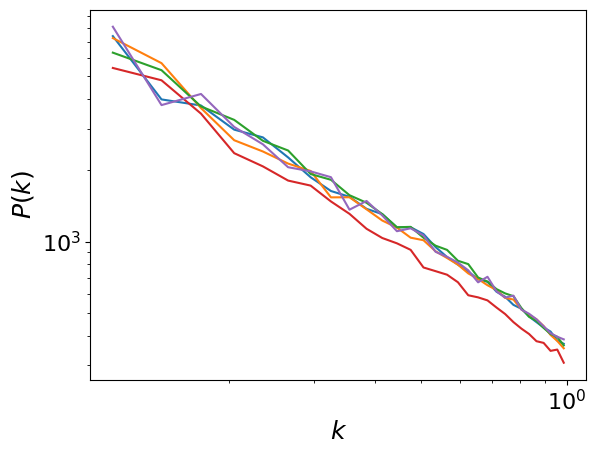

In [173]:
for i in range(len(sim_nums)):
    dat = dats_sam[i]
    
    x_arr = dat[:,galprop_fields.index('x_position')]
    y_arr = dat[:,galprop_fields.index('y_position')]
    z_arr = dat[:,galprop_fields.index('z_position')]
    pos_arr = np.array([x_arr, y_arr, z_arr])
    pk = bacco.statistics.compute_powerspectrum(pos=pos_arr.T, **args_power)

    plt.plot(pk['k'], pk['pk'])
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

## bacco emu for biased tracers in real space

In [74]:
emulator = baccoemu.Lbias_expansion()

  0% (0 of 12738560) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

Loading l-bias lpt emulator...


100% (12738560 of 12738560) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: Inconsi

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


100% (1146880 of 1146880) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
  1% (442368 of 34867200) |              | Elapsed Time: 0:00:00 ETA:  00:00:00

Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


100% (34867200 of 34867200) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
 10% (122880 of 1136640) |#              | Elapsed Time: 0:00:00 ETA:  00:00:00

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...


100% (1136640 of 1136640) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
  3% (270336 of 6922240) |               | Elapsed Time: 0:00:00 ETA:  00:00:00

Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...


100% (6922240 of 6922240) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [95]:
k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [82]:
# should this match camels??
params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [83]:
k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

In [ ]:
b1_min, b1_max = -0.25, 1.75
b2_min, b2_max = -1, 2
bs2_min, bs2_max = -3, 1
bl_min, bl_max = -5, 2

In [89]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_bounds = {'b1': [-0.25, 1.75],
               'b2': [-1, 2],
               'bs2': [-3, 1],
               'bl': [-5, 2],
              } 

In [84]:
#bias_params = [0.75, 0.25, 0.1, 1.4] # b1, b2, bs2, blaplacian


In [86]:
rng = np.random.default_rng(seed=42)

In [93]:
n_emu = 10
bias_param_arr = []
for bpn in bias_param_names:
    bias_params = rng.uniform(low=bias_bounds[bpn][0], high=bias_bounds[bpn][1], size=n_emu)
    bias_param_arr.append(bias_params)
bias_param_arr = np.array(bias_param_arr).T

Text(0, 0.5, '$P(k)$')

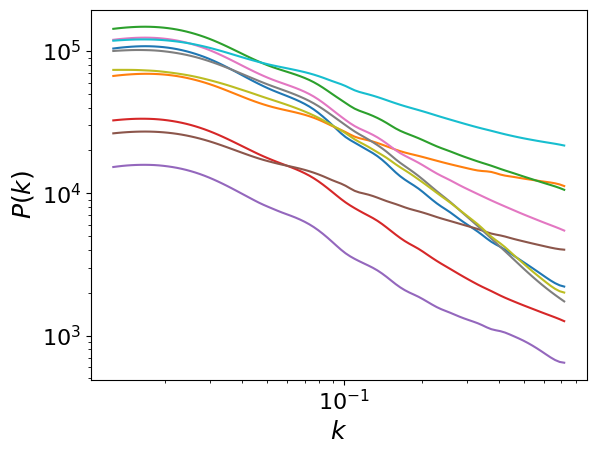

In [96]:
for i in range(n_emu):
    bias_params = bias_param_arr[i]
    k, p_gg, p_gm = emulator.get_galaxy_real_pk(bias=bias_params, k=k, **params)
    plt.plot(k, p_gg)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')